# Two point boundary value problems in Tensorflow


The two point boundary value problem is a syste of ordinary differential equations with boundary conditions in its domain. In general, it takes the form:
$$\frac{dy_i}{dx} = f(x, y_0,y_1, ..., y_N)$$
And if we want to solve it in $x \in (x_1, x_2)$, the boundary conditions are:
$$B_{1j}(x_1, y_0, y_1, ..., y_N) = 0$$
and
$$B_{2k}(x_1, y_0, y_1, ..., y_N) = 0$$

There are two types of numerical methods to solve this type of problem:
- Shooting method: In this method we fix the values at one boundary point that need to be consistent with the boundary conditions at this point, and we choose the rest of parameters more of less randomly. With this we can proceed to solve the ODE using any method, for example, a Runge-Kutta method. Then we will find a discrepancy with the boundary conditions at the other end, and we are left with a root finding problem. This is the approach that we are going to use with our tensorflow solution.
- Relaxation methods: Here, the differential equations are substituted by a finite-difference set of equations that cover the entire range of integration. The solution consist of, starting by an initial guess of the values for each element of the mesh, that doesn´t need to satisfy the differential equation, not the boundary conditions, and iteratively relaxe the values to satisfy all the conditions.


## Problem: Interception of a manouvering target.
The problem we are going to solve is the interception of a target that moves with constant acceleration, by an interceptor in a fixed time. The target is moving with an acceleration:
$$u_t(t)=\begin{Bmatrix} 
      1 \\ 
      -2 \\ 
      0.1
   \end{Bmatrix} m/s^2$$
The initial velocity and position is:
$$R_T(0)=\begin{Bmatrix} 
      500 \\ 
      -600 \\ 
      500
   \end{Bmatrix} m$$
$$V_T(0)=\begin{Bmatrix} 
  100 \\ 
  100 \\ 
  10
\end{Bmatrix} m/s$$

The interceptor is launched with an initial velocity of:
$$V(0)=\begin{Bmatrix} 
  150 \\ 
  40 \\ 
  5
\end{Bmatrix} m/s$$
And the time is $t_f=50s$.

### Equations to solve
$$\dot x = \begin{pmatrix} 
  0 & I \\ 
  0 & 0 \\ 
\end{pmatrix}x + \begin{Bmatrix} 
  0 \\ 
  I 
\end{Bmatrix}(u_T-u*)$$
$$u*=-\frac{t_f-t}{2\rho}\begin{Bmatrix} 
  \lambda _1 \\ 
  \lambda _2 \\ 
  \lambda _3 \\ 
\end{Bmatrix}$$

## Shooting method using tensorflow

In [6]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
%matplotlib inline 

# Global parameters
R = 1
t_f = 50
ut = [1., -2., 0.1]

ModuleNotFoundError: No module named 'tensorflow'

First we need to define the ODE to solve

In [ ]:
def interceptode(state, t):
    x, y, z, dx, dy, dz, l1, l2, l3 = tf.unstack(state)

    # At time greater than t_f, the acceleration of the interceptor is zero
    c = tf.cond(t < t_f, lambda: -(t_f - t) / 2.0*R, lambda: np.float64(0.0))

    x = dx
    y = dy
    z = dz
    dx = ut[0] - c*l1
    dy = ut[1] - c*l2
    dz = ut[2] - c*l3
    l1 = 0
    l2 = 0
    l3 = 0
    return tf.stack([x, y, z, dx, dy, dz, l1, l2, l3])

And then we can solve the ODE in tensorflow using odeint

In [ ]:
# This is needed for IPython
tf.reset_default_graph()

target = tf.Variable([0, 0, 0], dtype=tf.float64)

init_state = [np.float64(500), np.float64(-600), np.float64(500), np.float64(-50), np.float64(60), np.float64(5), 
              target[0], target[1], target[2]]
t = np.linspace(0, 50, num=500)
tensor_state = tf.contrib.integrate.odeint(
    interceptode, init_state, t)

The boundary conditions are going to be solved by reducing the error with tensorflow optimizer. Because we are using the shooting method the other boundary conditions were set as part of the ODE solver.

1338125.000000001
[-750. -100.  875.    0.  -40.   10.    0.    0.    0.]
2802437.8953823824
[-7.76320733e+02 -1.26956852e+03  7.66785361e+02 -7.89654450e-01
 -7.50884977e+01  6.75342739e+00 -1.26339511e-03 -5.61392855e-02
 -5.19430236e-03]
1216684.235561824
[ 3.50798274e+02  9.83362030e+02 -3.55842557e+02  3.30235942e+01
 -7.49948748e+00 -2.69248809e+01  5.28383280e-02  5.20013881e-02
 -5.90804549e-02]
660364.3745217742
[-1.55130177e+02 -7.85942609e+02  1.36356950e+02  1.78464753e+01
 -6.05787171e+01 -1.21597641e+01  2.85537508e-02 -3.29252445e-02
 -3.54548656e-02]
292669.6103270406
[ 3.84095725e+01  5.39624232e+02  5.42139056e-02  2.36520926e+01
 -2.08114309e+01 -1.62481577e+01  3.78436685e-02  3.07019705e-02
 -4.19974077e-02]
105203.25782721236
[ 4.80420917e+01 -3.06425841e+02 -9.48599986e+01  2.39403991e+01
 -4.61925518e+01 -1.90947504e+01  3.83060596e-02 -9.90845050e-03
 -4.65533276e-02]
54481.439389616455
[-1.12079868e+02  1.36822628e+02  1.52312544e+02  1.91376790e+01
 -3.289529

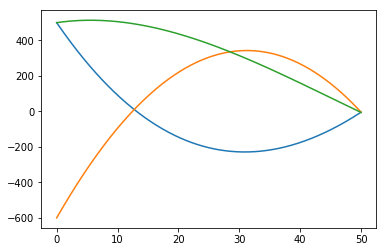

In [62]:
loss = tf.reduce_sum(tensor_state[-1][0]** 2 + tensor_state[-1][1]** 2 + tensor_state[-1][2]** 2)

train_step = tf.train.AdamOptimizer(0.1).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = []
trajectories = []
for i in range(100):
    loss_eval, state, _ = sess.run([loss, tensor_state, train_step])
    losses.append(loss_eval)
    trajectories.append(trajectory)
    if i % 5 == 0:
        print(loss_eval)
        print(state[-1])
state = sess.run([tensor_state])

And to plot the results:

In [ ]:
m = np.transpose(state)
x, y, z = m[0], m[1], m[2]
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.show()

If we execute the above code, we can see that this is not a very efficient way of solving this problem, it takes some time to reach a solution, but maybe with a finer mesh, or more complex problems it can be useful.

## Relaxation method with SciPy
 As a way of verifying the tensorflow solution, and to complete the analysis, here it is the implementation of the relaxation method to the same problem in python using SciPy boundary value problems solution.

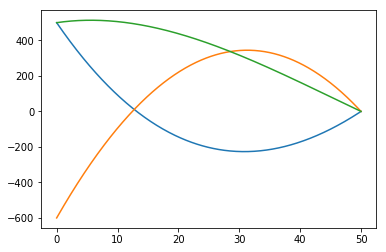

In [95]:
import numpy
from scipy.integrate import solve_bvp

R = 1
t_f = 50
ut = [1., -2., 0.1]
r0 = [500, -600, 500]
v0 = [-50, 60, 5]

def interceptode(t, state):

    c = -(t_f - t) / 2.0*R

    xx = state[3]
    yy = state[4]
    z = state[5]
    dx = ut[0] - c*state[6]
    dy = ut[1] - c*state[7]
    dz = ut[2] - c*state[8]
    l1 = np.zeros((1, xx.size))
    l2 = np.zeros((1, xx.size))
    l3 = np.zeros((1, xx.size))
    return numpy.vstack((xx, yy, z, dx, dy, dz, l1, l2, l3))

def boundary_conditions(Ta,Tb):

    return numpy.array([Ta[0] - r0[0], Ta[1] - r0[1], Ta[2] - r0[2], Ta[3] - v0[0], Ta[4] - v0[1], 
                         Ta[5] - v0[2], Tb[0], Tb[1], Tb[2]])

x = np.linspace(0, t_f, 500)
y = np.zeros((9, x.size))
res = solve_bvp(interceptode, boundary_conditions, x, y)
u = res.sol(x)[0]
y = res.sol(x)[1]
z = res.sol(x)[2]
plt.plot(x, u)
plt.plot(x, y)
plt.plot(x, z)
plt.show()